## Monthly Behavior – Time-Series EDA

Objective:
- Validate realism of customer behavioral time series
- Ensure signals evolve gradually, not randomly
- Confirm early deterioration patterns exist



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/raw/customer_monthly_behavior.csv")
df.head()

,customer_id,month,usage_index,arpu,discount,support_tickets,payment_delay_days
0,1,2020-01-01,0.532340,812.398700,0.0,3,0.420525
1,1,2020-02-01,0.280301,427.764123,0.0,1,1.933618
2,1,2020-03-01,0.160996,245.694819,0.0,1,3.059577
3,1,2020-04-01,0.089944,137.263132,0.0,2,4.217644
4,1,2020-05-01,0.051663,78.841682,0.0,1,4.706252


In [3]:
df.shape

(120000, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         120000 non-null  int64  
 1   month               120000 non-null  object 
 2   usage_index         120000 non-null  float64
 3   arpu                120000 non-null  float64
 4   discount            120000 non-null  float64
 5   support_tickets     120000 non-null  int64  
 6   payment_delay_days  120000 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 6.4+ MB


In [7]:
# Change the month column to datetime

df['month'] = pd.to_datetime(df['month'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   customer_id         120000 non-null  int64         
 1   month               120000 non-null  datetime64[ns]
 2   usage_index         120000 non-null  float64       
 3   arpu                120000 non-null  float64       
 4   discount            120000 non-null  float64       
 5   support_tickets     120000 non-null  int64         
 6   payment_delay_days  120000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 6.4 MB


In [8]:
df['customer_id'].nunique()

5000

In [10]:
df['month'].nunique()

24

In [11]:
# Check missing values

df.isna().sum()

customer_id           0
month                 0
usage_index           0
arpu                  0
discount              0
support_tickets       0
payment_delay_days    0
dtype: int64

In [12]:
df['month'].describe()

count                  120000
unique                     24
top       2020-01-01 00:00:00
freq                     5000
first     2020-01-01 00:00:00
last      2021-12-01 00:00:00
Name: month, dtype: object

### usage_index

In [13]:
df['usage_index'].describe()

count    120000.000000
mean          0.164448
std           0.214443
min           0.000000
25%           0.003197
50%           0.054722
75%           0.269435
max           0.996002
Name: usage_index, dtype: float64

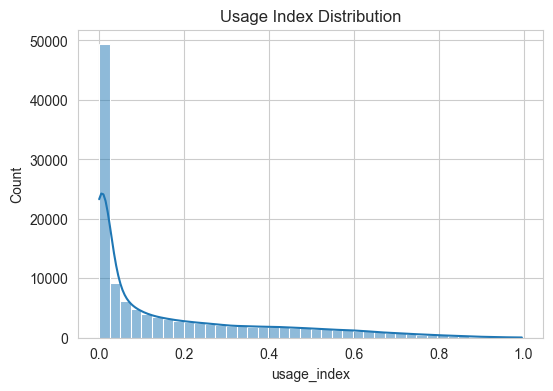

In [14]:
plt.figure(figsize=(6,4))
sns.histplot(df["usage_index"], bins=40, kde=True)
plt.title("Usage Index Distribution")
plt.show()


`Observation:`

- Values bounded [0,1]

- Skew toward healthy usage

- Realistic engagement decay

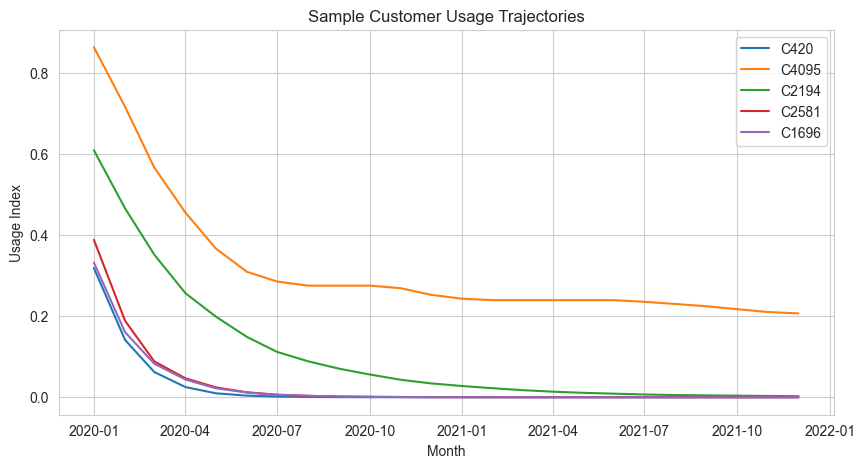

In [15]:
sample_ids = np.random.choice(df["customer_id"].unique(), 5, replace=False)

plt.figure(figsize=(10,5))
for cid in sample_ids:
    subset = df[df["customer_id"] == cid]
    plt.plot(subset["month"], subset["usage_index"], label=f"C{cid}")

plt.legend()
plt.title("Sample Customer Usage Trajectories")
plt.xlabel("Month")
plt.ylabel("Usage Index")
plt.show()


`Observation:`

- Smooth trajectories

- No violent random jumps

- Some decline patterns visible

### ARPU & Discount Dynamics

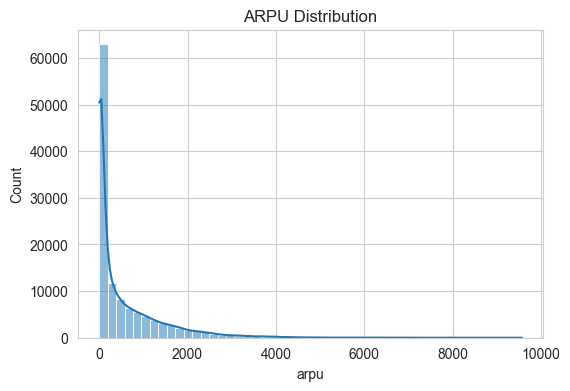

In [17]:
plt.figure(figsize=(6,4))
sns.histplot(df["arpu"], bins=50, kde=True)
plt.title("ARPU Distribution")
plt.show()


`Observation:`
- ARPU is right-skewed

### ARPU vs Discount Relationship

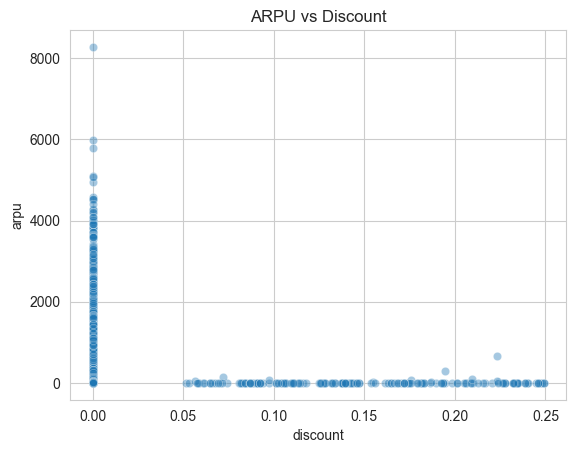

In [19]:
sns.scatterplot(
    x="discount",
    y="arpu",
    data=df.sample(3000),
    alpha=0.4
)
plt.title("ARPU vs Discount")
plt.show()


`Observation:`
- Discounts reduce ARPU

- No perfect linearity

### Discount Activation Over Time

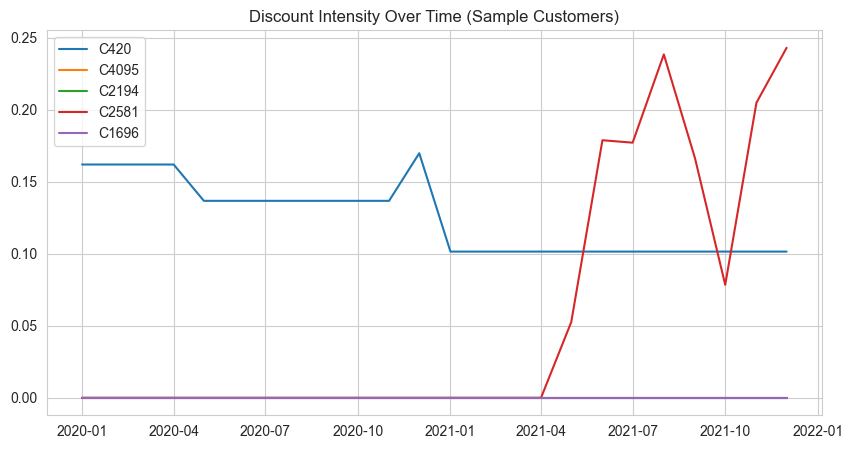

In [20]:
plt.figure(figsize=(10,5))
for cid in sample_ids:
    subset = df[df["customer_id"] == cid]
    plt.plot(subset["month"], subset["discount"], label=f"C{cid}")

plt.legend()
plt.title("Discount Intensity Over Time (Sample Customers)")
plt.show()


`Observation:`

- Discounts appear episodic
- Typically later in lifecycle

### Payment Stress Dynamics

#### Payment Delay Distribution

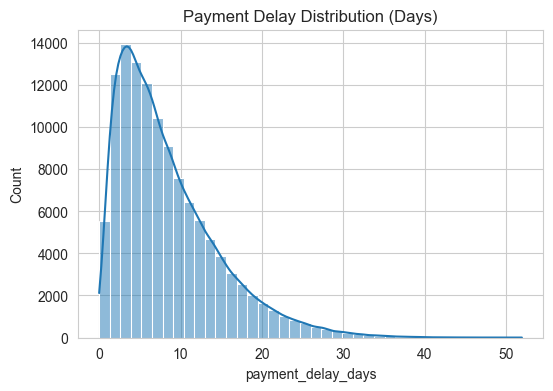

In [21]:
plt.figure(figsize=(6,4))
sns.histplot(df["payment_delay_days"], bins=40, kde=True)
plt.title("Payment Delay Distribution (Days)")
plt.show()


`Observation:`

- Skewed right → most customers pay on time, few are stressed.

#### Payment Delay Trajectories (Sample)

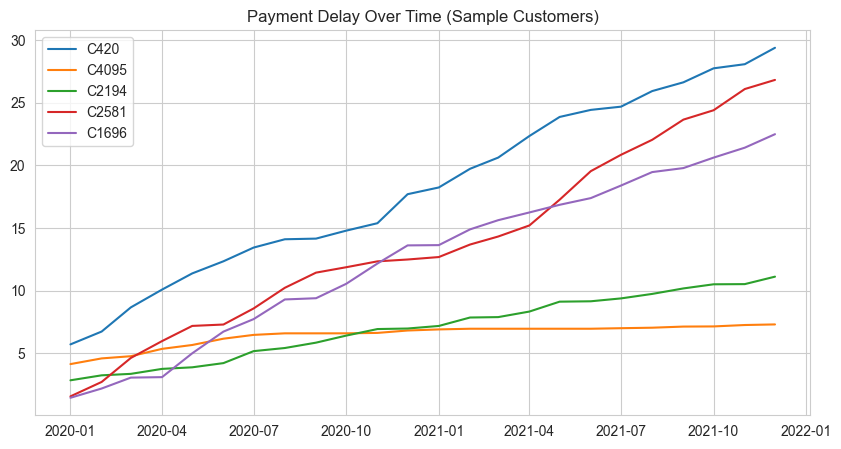

In [22]:
plt.figure(figsize=(10,5))
for cid in sample_ids:
    subset = df[df["customer_id"] == cid]
    plt.plot(subset["month"], subset["payment_delay_days"], label=f"C{cid}")

plt.legend()
plt.title("Payment Delay Over Time (Sample Customers)")
plt.show()


`Observation:`
- Gradual increase for stressed customers
- Not random spikes → strong early-warning signal

### Support Tickets as Friction Signal

#### Ticket Volume Distribution

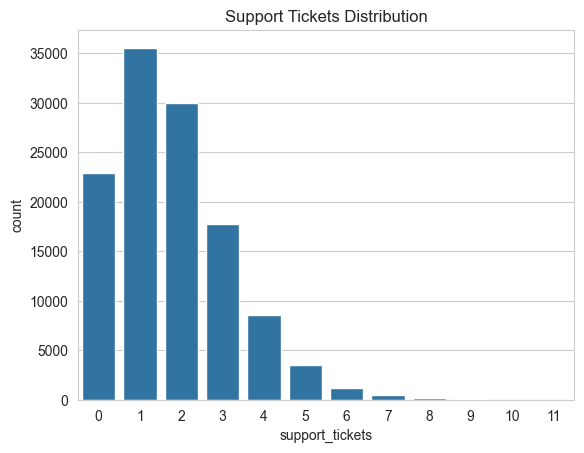

In [23]:
sns.countplot(x="support_tickets", data=df)
plt.title("Support Tickets Distribution")
plt.show()


`Observation:`
- Zero-inflated, Poisson-like → realistic ops data.

#### Ticket Bursts Over Time

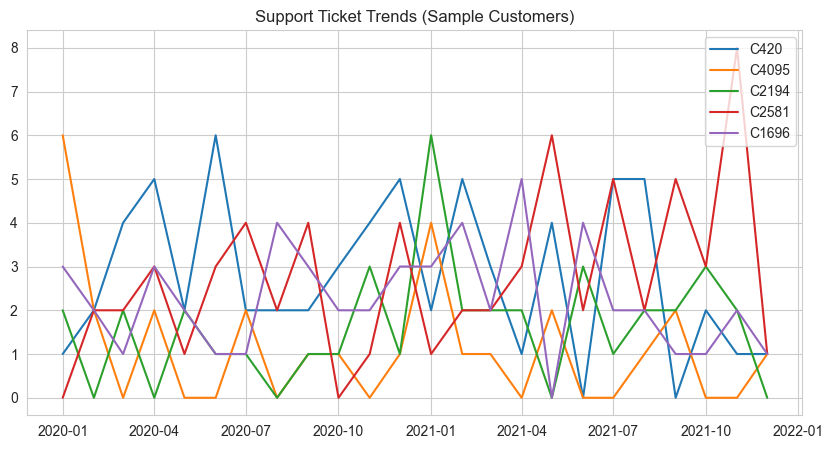

In [24]:
plt.figure(figsize=(10,5))
for cid in sample_ids:
    subset = df[df["customer_id"] == cid]
    plt.plot(subset["month"], subset["support_tickets"], label=f"C{cid}")

plt.legend()
plt.title("Support Ticket Trends (Sample Customers)")
plt.show()


`Observation:`
- Bursts exist
- Some customers show escalating friction

### Early-Warning Signal Check

#### Rolling Usage Decline

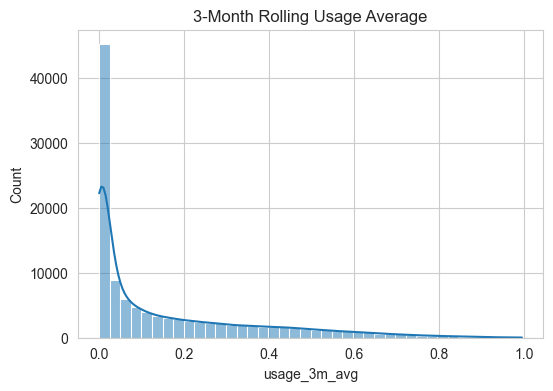

In [25]:
df_sorted = df.sort_values(["customer_id", "month"])
df_sorted["usage_3m_avg"] = (
    df_sorted.groupby("customer_id")["usage_index"]
    .rolling(3)
    .mean()
    .reset_index(level=0, drop=True)
)

plt.figure(figsize=(6,4))
sns.histplot(df_sorted["usage_3m_avg"].dropna(), bins=40, kde=True)
plt.title("3-Month Rolling Usage Average")
plt.show()


`Observation:`
- Rolling features are smooth
- Suitable for change-point detection

### Leakage Check


### Leakage Audit

This notebook intentionally avoids:
- Churn labels
- Churn month alignment
- Revenue loss data
  
Safe to proceed to feature engineering.

### Monthly Behavior EDA Summary

✔ Behavioral signals evolve smoothly over time  
✔ Usage decay, payment stress, and discounts show realistic dynamics  
✔ Support tickets exhibit burst patterns  
✔ Data supports early-warning and survival analysis  
✔ No label leakage detected  

Next step: Validate **churn event realism**.
